In [1]:
import os
import cv2
import seaborn as sn 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import VGG19
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [2]:
color = 'rgb' #'grayscale' o 'rgb'

escala = 150

In [3]:
def cargar_datos(path1, path2, escala = escala, color = color):
    
    EMD = os.listdir(path1)
    NO_EMD = os.listdir(path2)
    
    data = []
    labels = []

    for i in EMD:   
        image=tf.keras.preprocessing.image.load_img(path1+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(1)
    for i in NO_EMD:   
        image=tf.keras.preprocessing.image.load_img(path2+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(0)
        
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

### TRAIN: OCT + iPhone

### TEST: Samsung

In [4]:
dataset_iphone = cargar_datos('Datos EMD/iPhone/EMD', 'Datos EMD/iPhone/NO EMD')

In [5]:
dataset_samsung = cargar_datos('Datos EMD/Samsung/EMD', 'Datos EMD/Samsung/NO EMD')

In [6]:
dataset = cargar_datos('Datos EMD/OCT/EMD', 'Datos EMD/OCT/NO EMD')

In [7]:
train_ds = np.concatenate((dataset[0],dataset_iphone[0]))

train_labels = np.concatenate((dataset[1],dataset_iphone[1]))

In [8]:
test_ds = dataset_samsung[0]

test_labels = dataset_samsung[1]

In [9]:
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [10]:
## Loading VGG16 model
base_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [11]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/200
6/6 [==============================] - 9s 1s/step - loss: 4.3876 - accuracy: 0.5330 - val_loss: 1.0553 - val_accuracy: 0.7174
Epoch 2/200
6/6 [==============================] - 8s 1s/step - loss: 1.5536 - accuracy: 0.7747 - val_loss: 5.6540 - val_accuracy: 0.1304
Epoch 3/200
6/6 [==============================] - 10s 2s/step - loss: 0.8947 - accuracy: 0.7527 - val_loss: 1.3446 - val_accuracy: 0.6522
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 0.3564 - accuracy: 0.8901 - val_loss: 0.8195 - val_accuracy: 0.7609
Epoch 5/200
6/6 [==============================] - 10s 2s/step - loss: 0.1492 - accuracy: 0.9286 - val_loss: 1.5707 - val_accuracy: 0.5870
Epoch 6/200
6/6 [==============================] - 10s 2s/step - loss: 0.0793 - accuracy: 0.9670 - val_loss: 1.3696 - val_accuracy: 0.6087
Epoch 7/200
6/6 [==============================] - 10s 2s/step - loss: 0.0410 - accuracy: 0.9890 - val_loss: 1.6311 - val_accuracy: 0.5217
Epoch 8/200
6/6 [============

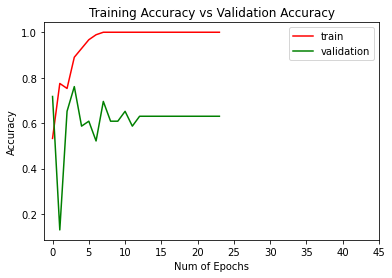

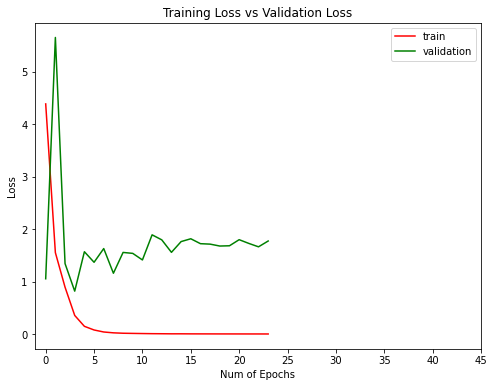

In [13]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

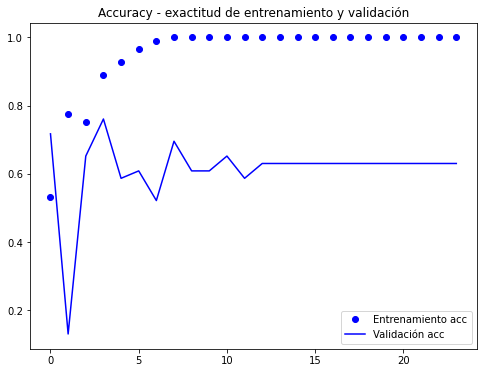

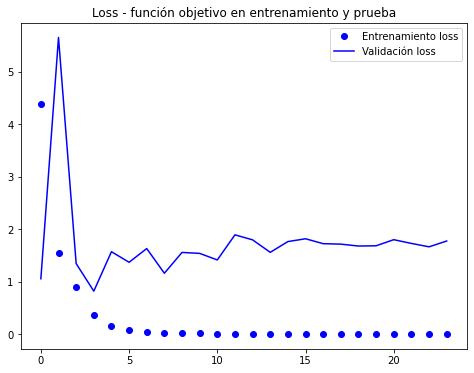

In [14]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 6s 1s/step


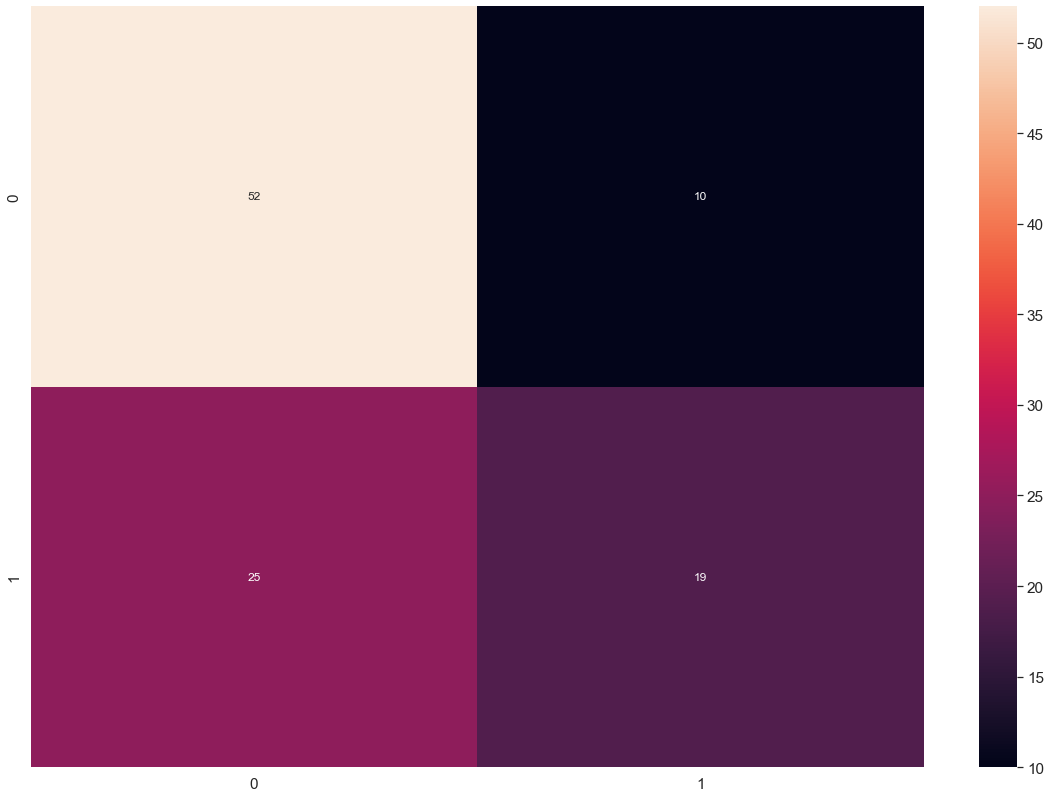

In [15]:
vgg19 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg19_predicted = np.argmax(vgg19, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels, axis=1), vgg19_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

**MÉTRICAS DE EVALUACIÓN**

In [16]:
score_test = model.evaluate(x=test_ds, y=test_labels, verbose = 0)

print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

Test loss: 1.6204969882965088
Test accuracy: 0.6698113083839417


In [17]:
predictions = model.predict(test_ds)

4/4 [==============================] - 4s 872ms/step


In [18]:
roc_score = roc_auc_score(test_labels, predictions, multi_class='ovr')

print(roc_score)

0.6304985337243403


In [19]:
snn_predicted = np.argmax(predictions, axis=1)
snn_report = classification_report(np.argmax(test_labels, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.68      0.84      0.75        62
           1       0.66      0.43      0.52        44

    accuracy                           0.67       106
   macro avg       0.67      0.64      0.63       106
weighted avg       0.67      0.67      0.65       106



### TRAIN: OCT + Samsung

### TEST: iPhone

In [20]:
train_ds = np.concatenate((dataset[0],dataset_samsung[0]))

train_labels = np.concatenate((dataset[1],dataset_samsung[1]))

In [21]:
test_ds = dataset_iphone[0]

test_labels = dataset_iphone[1]

In [22]:
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [23]:
## Loading VGG16 model
base_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [24]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/200
6/6 [==============================] - 9s 1s/step - loss: 2.9444 - accuracy: 0.6384 - val_loss: 12.7923 - val_accuracy: 0.1556
Epoch 2/200
6/6 [==============================] - 8s 1s/step - loss: 2.4521 - accuracy: 0.8023 - val_loss: 15.6981 - val_accuracy: 0.1111
Epoch 3/200
6/6 [==============================] - 9s 2s/step - loss: 1.0446 - accuracy: 0.8418 - val_loss: 5.8272 - val_accuracy: 0.3556
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 0.3173 - accuracy: 0.9040 - val_loss: 10.2990 - val_accuracy: 0.1333
Epoch 5/200
6/6 [==============================] - 10s 2s/step - loss: 0.3355 - accuracy: 0.9040 - val_loss: 6.5238 - val_accuracy: 0.3333
Epoch 6/200
6/6 [==============================] - 10s 2s/step - loss: 0.1529 - accuracy: 0.9435 - val_loss: 8.8350 - val_accuracy: 0.2000
Epoch 7/200
6/6 [==============================] - 10s 2s/step - loss: 0.0629 - accuracy: 0.9661 - val_loss: 9.5929 - val_accuracy: 0.2000
Epoch 8/200
6/6 [==========

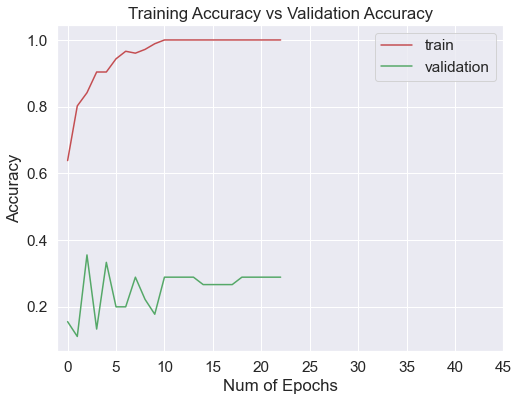

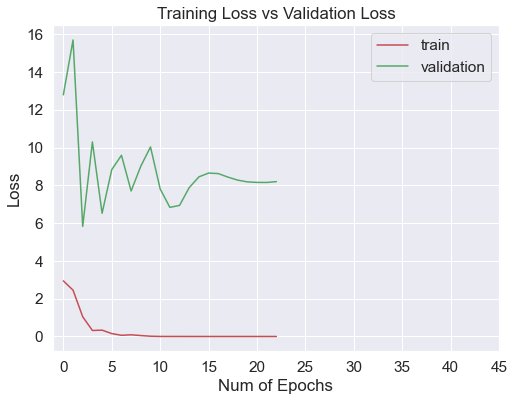

In [26]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

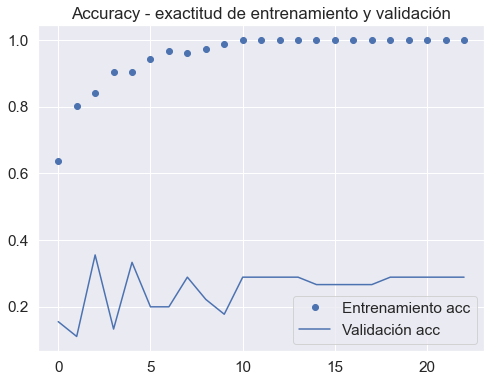

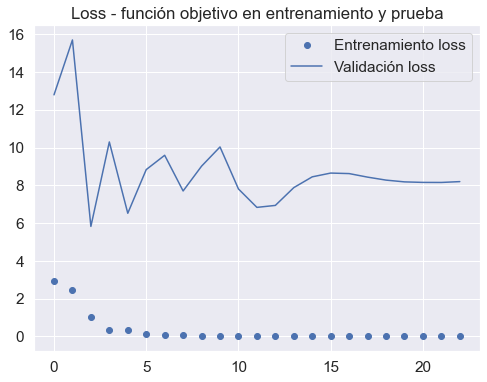

In [27]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 5s 1s/step


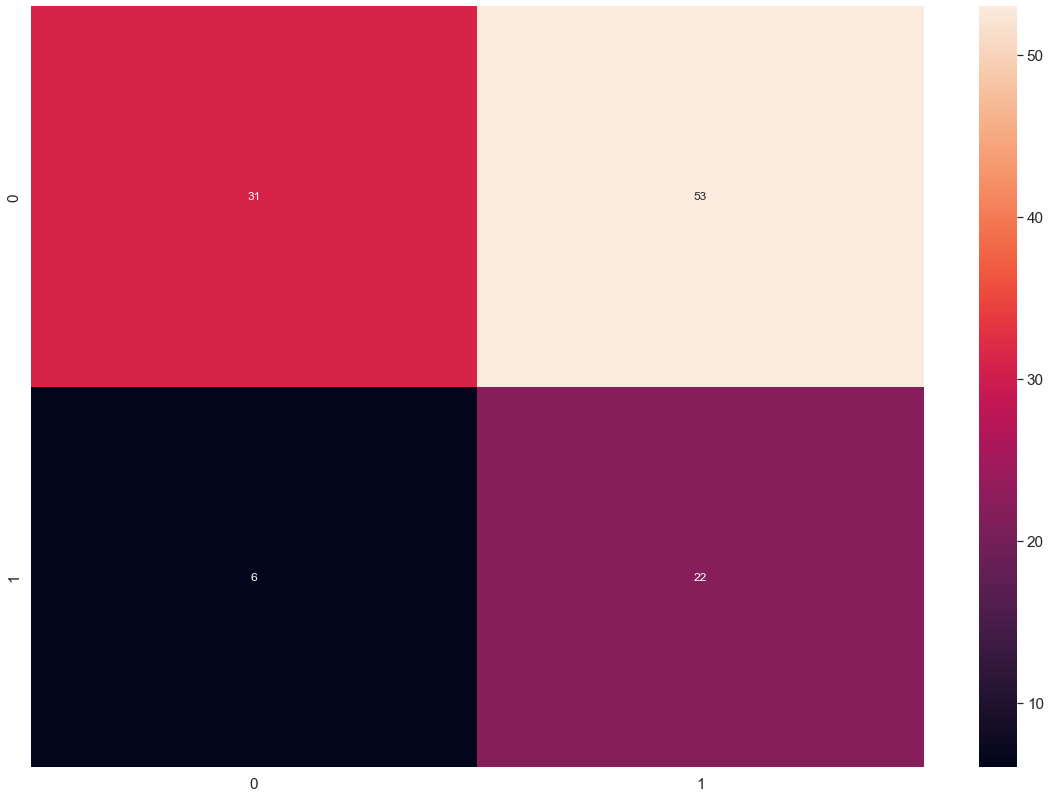

In [28]:
vgg19 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg19_predicted = np.argmax(vgg19, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels, axis=1), vgg19_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

**MÉTRICAS DE EVALUACIÓN**

In [29]:
score_test = model.evaluate(x=test_ds, y=test_labels, verbose = 0)

print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

Test loss: 3.2842748165130615
Test accuracy: 0.4732142984867096


In [30]:
predictions = model.predict(test_ds)

4/4 [==============================] - 4s 1s/step


In [31]:
roc_score = roc_auc_score(test_labels, predictions, multi_class='ovr')

print(roc_score)

0.6377551020408163


In [32]:
snn_predicted = np.argmax(predictions, axis=1)
snn_report = classification_report(np.argmax(test_labels, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.84      0.37      0.51        84
           1       0.29      0.79      0.43        28

    accuracy                           0.47       112
   macro avg       0.57      0.58      0.47       112
weighted avg       0.70      0.47      0.49       112

